# Radii fitting
read rdf and fit the radii  
read charge and sigma from itp file  

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit


In [2]:
# rdf peak fitting

def gaussian(x, amplitude, mean, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2 * standard_deviation**2))

def rdf_Gaussian_fit(rdf_arr, n_max, fun=gaussian, p0=None):
    """
    rdf_arr : np.array, (Nx2)
    n_max   : number of points used to fit Gaussian
    fun     : function to fit, default gaussian
    """
    max_map = np.argsort(rdf_arr[:, 1])[-n_max:]
    max_map.sort()
    
    x_data = rdf_arr[max_map, 0]
    y_data = rdf_arr[max_map, 1]
    params, covariance = curve_fit(gaussian, x_data, y_data, p0=p0, maxfev=5000)
    return (x_data, y_data), params



In [3]:
# read sigma and charge
def read_LJ(sigma_itp):
    with open(sigma_itp) as f:
        lines = f.readlines()
        for l in lines:
            l_tmp = l.rstrip().split(";")[0]
            if "_new" in l_tmp:
                words = l_tmp.split()
                sigma = float(words[5])
                epsilon = float(words[6])
                return sigma, epsilon

def read_charge(charge_itp):
    with open(charge_itp) as f:
        lines = f.readlines()
        for l in lines:
            l_tmp = l.rstrip().split(";")[0]
            if "_new" in l_tmp:
                words = l_tmp.split()
                chg = float(words[6])
                return chg

In [4]:
def read_all(base_win):
    sigma_itp = base_win / "K_ffnonbonded.itp"
    sigma, epsilon = read_LJ(sigma_itp)
    
    charge_itp = base_win / "ions.itp"
    chg = read_charge(charge_itp)
    
    rdf_xvg = base_win / "rdf/rdf.xvg"
    rdf_arr = np.loadtxt(rdf_xvg, comments=["@", "#"])
    p0 = [max(rdf_arr[:,1]),  rdf_arr[np.argmax(rdf_arr[:,1]), 0], 0.01]
    (x_data, y_data), params = rdf_Gaussian_fit(rdf_arr, n_max=7, fun=gaussian, p0=None)
    
    
    
    return (sigma, epsilon), chg, (rdf_arr, (x_data, y_data), params)

0-1.00


FileNotFoundError: 0-1.00/01-rad-scan/win_0/rdf/rdf.xvg not found.

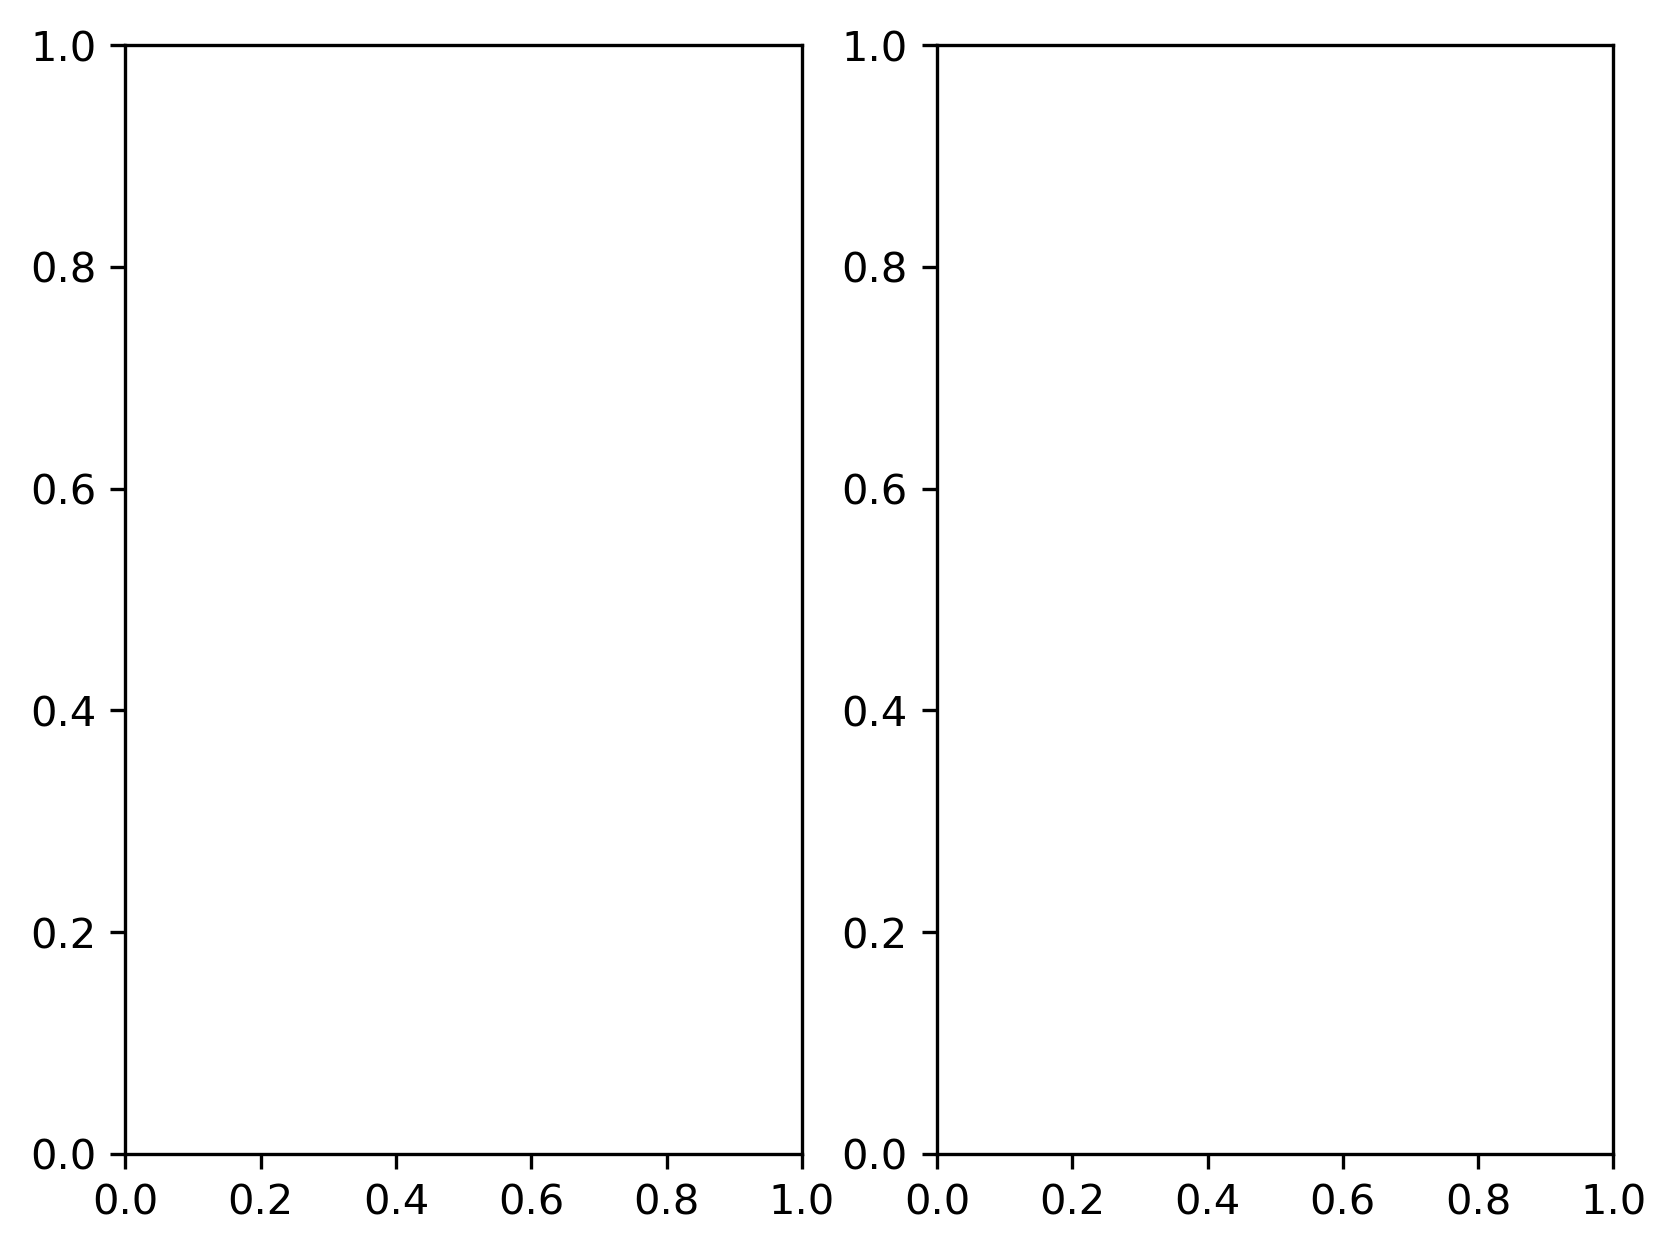

In [5]:
base=Path("./")
r_Marcus = 0.3187 # nm
r_0 = 0
for base_chg in base.glob('?-?.??'):
    print(base_chg)
    fix, (ax1, ax2) = plt.subplots(1,2,dpi=300)
    
    for base_win in base_chg.glob("01-rad-scan/win_?"):
        (sigma, epsilon), chg, (rdf_arr, (x_data, y_data), params) = read_all(base_win)
        ax1.scatter(y_data, x_data)
        x_line = np.linspace(min(x_data), max(x_data))
        amp, mean, std = params
        ax1.plot(gaussian(x_line, amp, mean, std), 
                 x_line,
                )
        ax2.scatter(sigma, mean)
        ax2.text(sigma, mean, f"sigma:{sigma:.3f}")
        print(mean)
    ax2.set_ylim(0.30, 0.33)
    ax1.set_ylim(0.30, 0.33)
    ax2.plot([0.42, 0.45], [r_Marcus, r_Marcus], c="black")
    ax2.text(0.42, r_Marcus-0.001, "Exp, Marcus")
    if r_0 == 0:
        r_0 = mean
    ax2.plot([0.42, 0.45], [r_0, r_0], c="black")
    ax2.text(0.42, r_0-0.001, "Amber")
    
    ax1.set_title("rdf peak fitting")
    ax1.set_ylabel("radius (nm)")
    ax2.set_title(f"sigma - radii chg={chg}")
    ax2.set_xlabel("sigma (nm)")
    xtick = 0.447766000 * np.linspace(1.025, 0.875, 7)
    ax2.set_xticks(xtick)
    ax2.set_xticklabels([f"{i:.3f}"  for i in xtick], rotation=45)
    ax2.grid()
    plt.savefig(f"chg{base_chg}.png")